In [175]:
%matplotlib inline

import glob
import os
from datetime import datetime

import pandas as pd
import numpy as np
from lxml import etree
import matplotlib.pyplot as plt
import seaborn as sns

import qgrid

from diligent import diligent

pd.set_option('display.max_columns', 200)

In [2]:
filenames = glob.glob('data/datenexport_20160407/*.xml')

In [228]:
XML_INFO = {
    'traeger_art': 'Traeger/Art/text()',
    'traeger_name': 'Traeger/Name/text()',
    'traeger_verband': 'Traeger/Verband_Der_Pflegeeinrichtung/text()',
    'start_date': 'Datum_Inbetriebnahme/text()',
    'start_date_contract': 'Datum_Versorgungsvertrag/text()',
    'belegt_vollstationär': 'Belegte_Plaetze/Vollstationaere_Pflege/text()',
    'belegt_kurzzeitpflege': 'Belegte_Plaetze/Kurzzeitpflege/text()',
    'personal_total': 'Personal/Gesamtzahl/text()',
    'personal_pflege': 'Personal/Pflege_Betreuung/text()',
    'grade_overall': 'Ergebnis[@bereich = "Gesamtnote"]/@note',
    'grade_care': 'Ergebnis[@bereich = "Bereich_1"]/@note',
    'check_type': 'Pruefungsart/text()',
}

def get_report_vars():
    for i in range(1, 32):
        yield 'T' + str(i).zfill(2)


for k in get_report_vars():
    XML_INFO[k] = 'Kriterium_ErfuelltBeiVon[@kriterium = "%s"]/@anzahl_bei' % k
    XML_INFO['%s_total' % k] = 'Kriterium_ErfuelltBeiVon[@kriterium = "%s"]/@anzahl_von' % k

def fix_xpath(xp):
    parts = xp.split('/')
    new_parts = []
    for p in parts:
        if p[0] != p[0].lower():
            p = '{ns}' + p
        new_parts.append(p)
    return '//' + '/'.join(new_parts)
        

NAMESPACE = 'GI4X:/xml-schema/Pflegebericht/1.0.13'

def xpath(root, xpath, ns=NAMESPACE):
    return etree.ETXPath(xpath.format(ns='{%s}' % ns))(root)


def get_first(iterable, default=None):
    if iterable:
        for item in iterable:
            return str(item)
    return default


def get_xml_data(tid):
    filename = 'data/datenexport_20160407/transparenzbericht_%d.xml' % tid
    if not os.path.exists(filename):
        return {
            k: None for k, _ in XML_INFO.items()
        }
    root = etree.fromstring(open(filename, 'rb').read())
    return {
        k: get_first(xpath(root, fix_xpath(v))) for k, v in XML_INFO.items()
    }

def add_xml_info(row):
    d = get_xml_data(row['ID'])
    for k, v in d.items():
        row[k] = v
    return row
    

In [4]:
import json
from rtree import index

from shapely.geometry import shape, Point

class GeoIndex(object):
    def __init__(self, filename):
        with open(filename) as f:
            js = json.load(f)
        self.idx = index.Index()
        self.features = js['features']
    
        for i, feature in enumerate(self.features):
            polygon = shape(feature['geometry'])
            self.idx.insert(i, polygon.bounds)

    def covers(self, lat, lng):
        point = Point(lng, lat)
        for j in self.idx.intersection(point.coords[0]):
            polygon = shape(self.features[j]['geometry'])
            if point.within(polygon):
                yield self.features[j]['properties']
    
    def get_feature_property(self, lat, lng, prop):
        l = list(self.covers(lat, lng))
        if l:
            return l[0][prop]
        return None
    
laender_index = GeoIndex('geodata/bundeslaender.geojson')
kreise_index = GeoIndex('geodata/landkreise.geojson')
assign_geofeature = lambda idx, key: lambda x: idx.get_feature_property(x.lat, x.lng, key)

In [225]:
def get_nursinghome_csv(filename='data/nursinghomes.csv'):
    if os.path.exists(filename):
        df = pd.read_csv(filename, parse_dates=True)
        df['letzte Aktualisierung durch Pflegeeinrichtung'] = pd.to_datetime(df['letzte Aktualisierung durch Pflegeeinrichtung'])
        return df

    df = pd.read_csv('data/datenexport_20160407/correctivExport.csv', encoding='latin1', sep=';')

    split_indicator = ['Minimum/Maximum', 'Gesamtpreis/Anteil Pflegekasse/Eigenanteil', 'Gesamtpreis/Anteil Pflegekasse']

    cost_columns = [c for c in df.columns if any([s in c for s in split_indicator])]


    def split_cost_column(column):
        def _split_cost_column(row):
            if pd.isnull(row[column]):
                return row
            amounts = row[column].replace('.', '').replace(',', '.').split('/')
            parts = column.split('/')
            name, first_part = parts[0].rsplit(' ', 1)
            name_parts = [first_part] + parts[1:]
            for n, a in zip(name_parts, amounts):
                row['%s %s' % (name, n)] = float(a) if a != 'null' else None
            return row
        return _split_cost_column

    for cost_column in cost_columns:
        df = df.apply(split_cost_column(cost_column), axis=1)
        del df[cost_column]

    print('Applying Geo Features')

    df = df.rename(columns={
        'Koordinate Latitude': 'lat',
        'Koordinate Longitude': 'lng'
    })

    df['bundesland'] = df[df.lat.notnull()].apply(assign_geofeature(laender_index, 'GEN'), axis=1)
    df['landkreis'] = df[df.lat.notnull()].apply(assign_geofeature(kreise_index, 'GEN'), axis=1)
    df['ags'] = df[df.lat.notnull()].apply(assign_geofeature(kreise_index, 'RS'), axis=1)
    df['Web'] = df['Web'].str.replace(' ', '').str.lower()

    df = df.apply(add_xml_info, axis=1)
    for c in ('grade_overall', 'grade_care'):
        df[c] = pd.to_numeric(df[c], errors='coerce')
    for c in ('start_date', 'start_date_contract'):
        df[c] = pd.to_datetime(df[c])
    for k in get_report_vars():
        df[k] = pd.to_numeric(df[k], errors='coerce')
        df[k + '_total'] = pd.to_numeric(df[k + '_total'], errors='coerce')

    df.to_csv(filename, encoding='utf-8')
    return df


df = get_nursinghome_csv()

df.head()

,Unnamed: 0,Ausstattung/Angebote: Bibliothek,Ausstattung/Angebote: Eigene Möbel,Ausstattung/Angebote: Fahrdienst,Ausstattung/Angebote: Fernseher,Ausstattung/Angebote: Garten,Ausstattung/Angebote: Hallenbad,Ausstattung/Angebote: Haustiere,Ausstattung/Angebote: Internet,Ausstattung/Angebote: Kegelbahn,Ausstattung/Angebote: Probewohnen,Ausstattung/Angebote: Sauna,Ausstattung/Angebote: Telefon,Ausstattung/Angebote: Übernachtung von Angehörigen,E-Mail,Fax,ID,Kontakt,lat,lng,Kurzzeitpflege Allgemein Härtefall Anteil Pflegekasse,Kurzzeitpflege Allgemein Härtefall Eigenanteil,Kurzzeitpflege Allgemein Härtefall Gesamtpreis,Kurzzeitpflege Allgemein Investitionskosten Maximum,Kurzzeitpflege Allgemein Investitionskosten Minimum,Kurzzeitpflege Allgemein Pflegestufe 1 Anteil Pflegekasse,Kurzzeitpflege Allgemein Pflegestufe 1 Eigenanteil,Kurzzeitpflege Allgemein Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Allgemein Pflegestufe 2 Anteil Pflegekasse,Kurzzeitpflege Allgemein Pflegestufe 2 Eigenanteil,Kurzzeitpflege Allgemein Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Allgemein Pflegestufe 3 Anteil Pflegekasse,Kurzzeitpflege Allgemein Pflegestufe 3 Eigenanteil,Kurzzeitpflege Allgemein Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Härtefall Anteil Pflegekasse,Kurzzeitpflege Beatmungspflichtig Härtefall Eigenanteil,Kurzzeitpflege Beatmungspflichtig Härtefall Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Investitionskosten Maximum,Kurzzeitpflege Beatmungspflichtig Investitionskosten Minimum,Kurzzeitpflege Beatmungspflichtig Pflegestufe 1 Anteil Pflegekasse,Kurzzeitpflege Beatmungspflichtig Pflegestufe 1 Eigenanteil,Kurzzeitpflege Beatmungspflichtig Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Pflegestufe 2 Anteil Pflegekasse,Kurzzeitpflege Beatmungspflichtig Pflegestufe 2 Eigenanteil,Kurzzeitpflege Beatmungspflichtig Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Pflegestufe 3 Anteil Pflegekasse,Kurzzeitpflege Beatmungspflichtig Pflegestufe 3 Eigenanteil,Kurzzeitpflege Beatmungspflichtig Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Demenzkrank Härtefall Anteil Pflegekasse,Kurzzeitpflege Demenzkrank Härtefall Eigenanteil,Kurzzeitpflege Demenzkrank Härtefall Gesamtpreis,Kurzzeitpflege Demenzkrank Investitionskosten Maximum,Kurzzeitpflege Demenzkrank Investitionskosten Minimum,Kurzzeitpflege Demenzkrank Pflegestufe 1 Anteil Pflegekasse,Kurzzeitpflege Demenzkrank Pflegestufe 1 Eigenanteil,Kurzzeitpflege Demenzkrank Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Demenzkrank Pflegestufe 2 Anteil Pflegekasse,Kurzzeitpflege Demenzkrank Pflegestufe 2 Eigenanteil,Kurzzeitpflege Demenzkrank Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Demenzkrank Pflegestufe 3 Anteil Pflegekasse,Kurzzeitpflege Demenzkrank Pflegestufe 3 Eigenanteil,Kurzzeitpflege Demenzkrank Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Wachkoma Härtefall Anteil Pflegekasse,Kurzzeitpflege Wachkoma Härtefall Eigenanteil,Kurzzeitpflege Wachkoma Härtefall Gesamtpreis,Kurzzeitpflege Wachkoma Investitionskosten Maximum,Kurzzeitpflege Wachkoma Investitionskosten Minimum,Kurzzeitpflege Wachkoma Pflegestufe 1 Anteil Pflegekasse,Kurzzeitpflege Wachkoma Pflegestufe 1 Eigenanteil,Kurzzeitpflege Wachkoma Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Wachkoma Pflegestufe 2 Anteil Pflegekasse,Kurzzeitpflege Wachkoma Pflegestufe 2 Eigenanteil,Kurzzeitpflege Wachkoma Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Wachkoma Pflegestufe 3 Anteil Pflegekasse,Kurzzeitpflege Wachkoma Pflegestufe 3 Eigenanteil,Kurzzeitpflege Wachkoma Pflegestufe 3 Gesamtpreis,Nachtpflege Allgemein Investitionskosten Maximum,Nachtpflege Allgemein Investitionskosten Minimum,Nachtpflege Allgemein Pflegestufe 1 Anteil Pflegekasse,Nachtpflege Allgemein Pflegestufe 1 Eigenanteil,Nachtpflege Allgemein Pflegestufe 1 Gesamtpreis,Nachtpflege Allgemein Pflegestufe 2 Anteil Pflegekasse,Nachtpflege Allgemein Pflegestufe 2 Eigenanteil,Nachtpflege Allgemein Pflegestufe 2 Gesamtpreis,Nachtpflege Allgemein Pflegestufe 3 Anteil Pflegekasse,Nac

## What’s the county with the most expensive nursing homes? (Pflegeklasse 1, 2, 3 + UV / jeweils für Dauerpflege und Kurzzeitpflege)

In [7]:
def get_top_10_by_value(value, index='landkreis', top=10, asc=False):
    print('## ' + value)
    print(df.pivot_table(index=index, values=value, aggfunc=np.mean).sort_values(ascending=asc).head(10))
    print('-' * 20)

columns = [c for c in df.columns if 'Vollstationär Allgemein' in c and 'Gesamtpreis' in c]
for c in columns:
    get_top_10_by_value(c)

## Vollstationär Allgemein Härtefall Gesamtpreis
landkreis
Stuttgart                      4186.301471
St. Wendel                     4152.600000
Böblingen                      4128.381081
Steinfurt                      4090.200000
Landau in der Pfalz            4061.500000
Eifelkreis Bitburg-Prüm        4054.800000
Trier                          4053.200000
Neunkirchen                    4030.617391
Regionalverband Saarbrücken    4026.273333
Ludwigsburg                    4023.319565
Name: Vollstationär Allgemein Härtefall Gesamtpreis, dtype: float64
--------------------
## Vollstationär Allgemein Pflegestufe 1 Gesamtpreis
landkreis
Siegen-Wittgenstein    2788.850000
Kaufbeuren             2716.140000
Köln                   2705.416484
Krefeld                2653.834615
München                2631.289286
St. Wendel             2614.600000
Remscheid              2614.480000
Mülheim an der Ruhr    2608.263158
Steinfurt              2598.656897
Viersen                2597.100000
Name: Vol

In [8]:
columns = [c for c in df.columns if 'Kurzzeitpflege Allgemein' in c and 'Gesamtpreis' in c]
for c in columns:
    get_top_10_by_value(c)

## Kurzzeitpflege Allgemein Härtefall Gesamtpreis
landkreis
Cloppenburg                    4758.600000
Neckar-Odenwald-Kreis          4746.300000
Osnabrück                      4493.700000
Reutlingen                     4398.525000
Sigmaringen                    4219.500000
Würzburg                       4173.900000
Neunkirchen                    4171.125000
Stuttgart                      4104.750000
Regionalverband Saarbrücken    4082.817391
Rems-Murr-Kreis                4043.127273
Name: Kurzzeitpflege Allgemein Härtefall Gesamtpreis, dtype: float64
--------------------
## Kurzzeitpflege Allgemein Pflegestufe 1 Gesamtpreis
landkreis
Neckar-Odenwald-Kreis    4746.300000
Heidelberg               3496.800000
Würzburg                 3060.900000
München                  2952.900000
Fürstenfeldbruck         2910.600000
Berchtesgadener Land     2845.200000
Berlin                   2766.763636
Ravensburg               2741.340000
Reutlingen               2731.140000
Sigmaringen            

## What’s the county with the cheapest nursing homes? (Pflegeklasse 1, 2, 3 + UV / jeweils für Dauerpflege und Kurzzeitpflege)

In [9]:
columns = [c for c in df.columns if 'Vollstationär Allgemein' in c and 'Gesamtpreis' in c]
for c in columns:
    get_top_10_by_value(c, asc=True)

## Vollstationär Allgemein Härtefall Gesamtpreis
landkreis
Wilhelmshaven            2727.521053
Unstrut-Hainich-Kreis    2825.385000
Osterode am Harz         2860.848387
Uelzen                   2861.466667
Holzminden               2866.248000
Peine                    2871.912500
Rostock                  2872.730769
Lüneburg                 2874.618182
Schaumburg               2875.104878
Ludwigslust-Parchim      2881.008333
Name: Vollstationär Allgemein Härtefall Gesamtpreis, dtype: float64
--------------------
## Vollstationär Allgemein Pflegestufe 1 Gesamtpreis
landkreis
Unstrut-Hainich-Kreis    1619.580000
Dresden                  1623.621429
Chemnitz                 1641.193548
Mittelsachsen            1648.406897
Leipzig                  1651.989320
Rostock                  1655.511864
Ludwigslust-Parchim      1657.708333
Mansfeld-Südharz         1658.545455
Zwickau                  1660.189655
Vogtlandkreis            1664.175000
Name: Vollstationär Allgemein Pflegestufe 1 Gesam

In [10]:
columns = [c for c in df.columns if 'Kurzzeitpflege Allgemein' in c and 'Gesamtpreis' in c]
for c in columns:
    get_top_10_by_value(c, asc=True)

## Kurzzeitpflege Allgemein Härtefall Gesamtpreis
landkreis
Mannheim                 2136.600000
Herzogtum Lauenburg      2545.053659
Rendsburg-Eckernförde    2553.117647
Steinburg                2587.977778
Oldenburg                2592.300000
Segeberg                 2596.535714
Ostholstein              2605.654286
Schleswig-Flensburg      2659.555102
Nordfriesland            2670.171429
Dithmarschen             2678.334375
Name: Kurzzeitpflege Allgemein Härtefall Gesamtpreis, dtype: float64
--------------------
## Kurzzeitpflege Allgemein Pflegestufe 1 Gesamtpreis
landkreis
Oldenburg                1567.500000
Unstrut-Hainich-Kreis    1619.580000
Vogtlandkreis            1653.042857
Friesland                1661.400000
Nordwestmecklenburg      1673.130000
Saalfeld-Rudolstadt      1685.333333
Gotha                    1685.966667
Kyffhäuserkreis          1688.841176
Greiz                    1691.175000
Wittmund                 1694.100000
Name: Kurzzeitpflege Allgemein Pflegestufe 1 G

### These questions related to cost can also be calculated compared to the the gross domestic product of the counties / states. It can also be calculated compared to the annual income of the people living in these counties / states.

In [11]:
def get_income_df(sheet='PEK je Einwohner'):
    income_df = pd.read_excel('data/VGR_KreisergebnisseBand3_5820008147005.xlsx', sheetname=sheet, skiprows=4)
    income_df = income_df.rename(columns={
            'Regional-schlüssel': 'ags'
        })
    income_df = income_df[~income_df['ags'].isnull()]
    income_df['ags'] = income_df['ags'].apply(lambda x: str(int(x)).zfill(5))

    income_years = list(range(2000, 2014))
    id_vars = ['ags', 'Gebietseinheit']
    income_df = pd.melt(income_df[income_years + id_vars], id_vars=id_vars, var_name='year', value_name=sheet)
    income_df[sheet] = pd.to_numeric(income_df[sheet], errors='coerce')
    income_df = income_df.set_index('ags')
    return income_df

In [12]:
income_df = get_income_df()
income_df[income_df.year == 2013].sort_values(by='PEK je Einwohner').head()

,Gebietseinheit,year,PEK je Einwohner
ags,,,
15087,"Mansfeld-Südharz, Landkreis",2013,15278.0
14626,"Görlitz, Landkreis",2013,15390.0
04012,"Bremerhaven, Kreisfreie Stadt",2013,15467.0
15089,Salzlandkreis,2013,15846.0
12066,"Oberspreewald-Lausitz, Landkreis",2013,15924.0


In [13]:
df = df.merge(income_df[income_df.year == 2013][['PEK je Einwohner']], left_on='ags', right_index=True)

In [14]:
columns = [c for c in df.columns if 'Vollstationär Allgemein' in c and 'Gesamtpreis' in c]
for c in columns:
    df['%s Ratio PEK/Einwohner' % c] = df[c] / df['PEK je Einwohner']

In [15]:
columns = [c for c in df.columns if 'Vollstationär Allgemein' in c and 'Gesamtpreis' in c and 'Ratio PEK/Einwohner' in c]
for c in columns:
    get_top_10_by_value(c)

## Vollstationär Allgemein Härtefall Gesamtpreis Ratio PEK/Einwohner
landkreis
Bremerhaven                    0.220120
Görlitz                        0.201192
Pirmasens                      0.195452
Uckermark                      0.195260
Offenbach am Main              0.194736
Merzig-Wadern                  0.194325
Regionalverband Saarbrücken    0.192075
Nordhausen                     0.191999
Oberspreewald-Lausitz          0.191347
Neunkirchen                    0.191079
Name: Vollstationär Allgemein Härtefall Gesamtpreis Ratio PEK/Einwohner, dtype: float64
--------------------
## Vollstationär Allgemein Pflegestufe 1 Gesamtpreis Ratio PEK/Einwohner
landkreis
Duisburg                       0.132934
Gelsenkirchen                  0.130309
Bremerhaven                    0.125933
Herne                          0.123669
Uckermark                      0.119633
Oberhausen                     0.118113
Hamm                           0.117871
Merzig-Wadern                  0.117259
Pirmasens

In [20]:
income_df.sort_values('PEK je Einwohner').head()

,Gebietseinheit,year,PEK je Einwohner
ags,,,
15087,"Mansfeld-Südharz, Landkreis",2000,10704.0
15089,Salzlandkreis,2000,10848.0
14626,"Görlitz, Landkreis",2000,10884.0
15082,"Anhalt-Bitterfeld, Landkreis",2000,10895.0
12066,"Oberspreewald-Lausitz, Landkreis",2000,10963.0


## How old are the nursing homes on a national / state / county level?

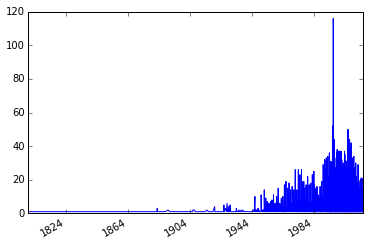

In [36]:
df['start_date'].value_counts().plot()

In [72]:
df['days_in_operation'] = (datetime.now() - df['start_date']).apply(lambda x: None if pd.isnull(x) else x.days)
print('Median years overall', df['days_in_operation'].median() / 365)
df.groupby('bundesland')['days_in_operation'].median() / 365

Median years overall 16.20958904109589


bundesland
Baden-Württemberg         15.346575
Bayern                    18.731507
Brandenburg               12.932877
Bremen                    16.983562
Hessen                    16.816438
Mecklenburg-Vorpommern    15.389041
Niedersachsen             14.895890
Nordrhein-Westfalen       19.731507
Rheinland-Pfalz           18.405479
Saarland                  10.893151
Sachsen                   14.186301
Sachsen-Anhalt            13.895890
Schleswig-Holstein        16.312329
Thüringen                 13.224658
Name: days_in_operation, dtype: float64

The top and bottom 10 of counties by median age of their nursing homes, and the number of nursing homes in that county.

In [95]:
def median_years(x):
    return x.median() / 365

median_age_years_counties = df.groupby(['ags', 'landkreis'])['days_in_operation'].agg([median_years, len]).sort_values(by='median_years')
median_age_years_counties.head(10)

,,median_years,len
ags,landkreis,,
07340,Südwestpfalz,6.638356,9.0
10043,Neunkirchen,6.869863,26.0
03458,Oldenburg,7.704110,45.0
09679,Würzburg,7.975342,29.0
16074,Saale-Holzland-Kreis,8.136986,15.0
16069,Hildburghausen,8.286301,19.0
10044,Saarlouis,8.632877,33.0
16056,Eisenach,9.019178,13.0
16054,Suhl,9.189041,12.0


In [96]:
median_age_years_counties.tail(10)

,,median_years,len
ags,landkreis,,
09261,Landshut,30.634247,11.0
05316,Leverkusen,30.654795,16.0
07320,Zweibrücken,31.600000,3.0
09463,Coburg,32.405479,10.0
09764,Memmingen,32.573973,7.0
07313,Landau in der Pfalz,32.909589,5.0
09461,Bamberg,35.702740,14.0
09163,Rosenheim,40.490411,5.0
07111,Koblenz,43.517808,17.0


### Oldest and youngest nursing homes in data

In [88]:
print('%d of %d nursing homes without a start date' % (df['start_date'].isnull().sum(), len(df)))

3976 of 14386 nursing homes without a start date


In [81]:
df[['Name', 'PLZ', 'days_in_operation', 'start_date']].sort_values(by='days_in_operation', ascending=False).head()

,Name,PLZ,days_in_operation,start_date
13531,Fürstlich Waldburg-Zeil'sche Hospitalverwaltung,88353,79002.0,1800-01-01
11384,Stiftung ev. Altenheim Ludwigsburg,71640,65641.0,1836-08-01
12276,Alten- und Pflegeheim Braunsche Stiftung,76761,62201.0,1846-01-01
13588,Spital- und Spendfonds Überlingen St. Franzisk...,88662,59644.0,1853-01-01
9034,Schenkel-Schoeller-Stift,52355,57078.0,1860-01-11


In [83]:
df[['Name', 'PLZ', 'days_in_operation', 'start_date']][df['days_in_operation'].notnull()].sort_values(by='days_in_operation', ascending=False).tail()

,Name,PLZ,days_in_operation,start_date
11994,Dienste für Menschen gGmbH Pflegestift Gundels...,74831,202.0,2015-10-01
1048,Altenpflegeheim Luisenhaus,6618,177.0,2015-10-26
4661,Seniorenbetreuung Neuenkirchen,28790,171.0,2015-11-01
5943,Seniorenheim Landgrafenblick GmbH,35039,171.0,2015-11-01
3583,Domicil-Seniorenpflegeheim Kirchhofallee GmbH ...,24114,171.0,2015-11-01


## Where are the best nursing homes according to the grades for 1) overall and 2) medical and nursing?

In [101]:
print('Median overall grade', df['grade_overall'].median())
df.groupby('bundesland')['grade_overall'].median()

Median overall grade 1.2


bundesland
Baden-Württemberg         1.1
Bayern                    1.3
Brandenburg               1.1
Bremen                    1.3
Hessen                    1.2
Mecklenburg-Vorpommern    1.1
Niedersachsen             1.2
Nordrhein-Westfalen       1.2
Rheinland-Pfalz           1.4
Saarland                  1.0
Sachsen                   1.1
Sachsen-Anhalt            1.1
Schleswig-Holstein        1.3
Thüringen                 1.3
Name: grade_overall, dtype: float64

Showing the bottom counties, top counties are all 1.0

In [104]:
median_grade_counties = df.groupby(['ags', 'landkreis'])['grade_overall'].agg([np.median, len]).sort_values(by='median')
median_grade_counties.tail(10)

,,median,len
ags,landkreis,,
07332,Bad Dürkheim,1.55,15.0
09173,Bad Tölz-Wolfratshausen,1.55,14.0
07137,Mayen-Koblenz,1.55,28.0
05914,Hagen,1.55,28.0
09463,Coburg,1.60,10.0
09571,Ansbach,1.60,29.0
07135,Cochem-Zell,1.60,14.0
09577,Weißenburg-Gunzenhausen,1.65,17.0
07141,Rhein-Lahn-Kreis,1.70,15.0


In [123]:
median_grade_counties.sort_values('median').head(10)

,,median,len
ags,landkreis,,
12073,Uckermark,1.0,30.0
12072,Teltow-Fläming,1.0,31.0
12070,Prignitz,1.0,26.0
10046,St. Wendel,1.0,23.0
05370,Heinsberg,1.0,68.0
10045,Saarpfalz-Kreis,1.1,19.0
10044,Saarlouis,1.1,33.0
10042,Merzig-Wadern,1.1,24.0
15091,Wittenberg,1.1,21.0


### Medical grade

In [120]:
print('Median overall grade', df['grade_care'].median())
df.groupby('bundesland')['grade_care'].median()

Median overall grade 1.4


bundesland
Baden-Württemberg         1.30
Bayern                    1.50
Brandenburg               1.20
Bremen                    1.60
Hessen                    1.30
Mecklenburg-Vorpommern    1.30
Niedersachsen             1.50
Nordrhein-Westfalen       1.30
Rheinland-Pfalz           1.70
Saarland                  1.10
Sachsen                   1.20
Sachsen-Anhalt            1.30
Schleswig-Holstein        1.50
Thüringen                 1.55
Name: grade_care, dtype: float64

In [126]:
median_grade_care_counties = df.groupby(['ags', 'landkreis'])['grade_care'].agg([np.median, len]).sort_values(by='median')
median_grade_care_counties.tail(10)

,,median,len
ags,landkreis,,
07332,Bad Dürkheim,1.95,15.0
09463,Coburg,1.95,10.0
16068,Sömmerda,2.00,14.0
07334,Germersheim,2.00,13.0
07137,Mayen-Koblenz,2.00,28.0
09173,Bad Tölz-Wolfratshausen,2.10,14.0
09571,Ansbach,2.10,29.0
07135,Cochem-Zell,2.30,14.0
07141,Rhein-Lahn-Kreis,2.30,15.0


In [127]:
median_grade_care_counties.sort_values('median').head(10)

,,median,len
ags,landkreis,,
12073,Uckermark,1.0,30.0
12072,Teltow-Fläming,1.0,31.0
12070,Prignitz,1.0,26.0
10046,St. Wendel,1.0,23.0
05370,Heinsberg,1.0,68.0
10045,Saarpfalz-Kreis,1.1,19.0
10044,Saarlouis,1.1,33.0
10042,Merzig-Wadern,1.1,24.0
15091,Wittenberg,1.1,21.0


### How many nursing homes have which kind of owners (private vs non-profit) on a national / state / county level?

In [131]:
print('{} nursing homes without ownership kind'.format(df['traeger_art'].isnull().sum()))
df['traeger_art'].value_counts()

3680 nursing homes without ownership kind


freigemeinnützig      5968
privat                4280
öffentlich             422
nicht zu ermitteln      36
Name: traeger_art, dtype: int64

In [129]:
# In percent
df['traeger_art'].value_counts() / df['traeger_art'].value_counts().sum() * 100

freigemeinnützig      55.744442
privat                39.977583
öffentlich             3.941715
nicht zu ermitteln     0.336260
Name: traeger_art, dtype: float64

In [165]:
ownership_kind = df.groupby(['bundesland', 'traeger_art']).size(
)

ownership_kind_pivot = ownership_kind.reset_index().pivot_table(index='bundesland', columns='traeger_art',
                                         values=0, fill_value=0, margins=True)
ownership_kind_pivot

traeger_art,freigemeinnützig,nicht zu ermitteln,privat,öffentlich,All
bundesland,,,,,
Baden-Württemberg,929.000000,0.0,442.000000,100.000000,490.333333
Bayern,863.000000,0.0,514.000000,140.000000,505.666667
Brandenburg,189.000000,0.0,90.000000,4.000000,94.333333
Bremen,67.000000,0.0,46.000000,1.000000,38.000000
Hessen,390.000000,2.0,365.000000,31.000000,197.000000
Mecklenburg-Vorpommern,160.000000,3.0,69.000000,13.000000,61.250000
Niedersachsen,494.000000,0.0,900.000000,31.000000,475.000000
Nordrhein-Westfalen,1429.000000,2.0,662.000000,47.000000,535.000000
Rheinland-Pfalz,258.000000,3.0,173.000000,6.000000,110.000000


In [171]:
county_ownership_kinds = df.groupby(['ags', 'landkreis', 'traeger_art']).size().unstack().fillna(0)

In [174]:
qgrid.show_grid(county_ownership_kinds)

## How does that correlate to be a patient in these nursing homes? (as in: are private nursing homes cheaper?)

In [184]:
price_cats = [c for c in df.columns if 'Gesamtpreis' in c and not 'Ratio' in c]
ownership_kind_prices = df.groupby('traeger_art')[price_cats].mean()
ownership_kind_prices

,Kurzzeitpflege Allgemein Härtefall Gesamtpreis,Kurzzeitpflege Allgemein Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Allgemein Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Allgemein Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Härtefall Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Beatmungspflichtig Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Demenzkrank Härtefall Gesamtpreis,Kurzzeitpflege Demenzkrank Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Demenzkrank Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Demenzkrank Pflegestufe 3 Gesamtpreis,Kurzzeitpflege Wachkoma Härtefall Gesamtpreis,Kurzzeitpflege Wachkoma Pflegestufe 1 Gesamtpreis,Kurzzeitpflege Wachkoma Pflegestufe 2 Gesamtpreis,Kurzzeitpflege Wachkoma Pflegestufe 3 Gesamtpreis,Nachtpflege Allgemein Pflegestufe 1 Gesamtpreis,Nachtpflege Allgemein Pflegestufe 2 Gesamtpreis,Nachtpflege Allgemein Pflegestufe 3 Gesamtpreis,Nachtpflege Demenzkrank Pflegestufe 1 Gesamtpreis,Nachtpflege Demenzkrank Pflegestufe 2 Gesamtpreis,Nachtpflege Demenzkrank Pflegestufe 3 Gesamtpreis,Tagespflege Allgemein Härtefall Gesamtpreis,Tagespflege Allgemein Pflegestufe 1 Gesamtpreis,Tagespflege Allgemein Pflegestufe 2 Gesamtpreis,Tagespflege Allgemein Pflegestufe 3 Gesamtpreis,Tagespflege Demenzkrank Pflegestufe 1 Gesamtpreis,Tagespflege Demenzkrank Pflegestufe 2 Gesamtpreis,Tagespflege Demenzkrank Pflegestufe 3 Gesamtpreis,Vollstationär Allgemein Härtefall Gesamtpreis,Vollstationär Allgemein Pflegestufe 1 Gesamtpreis,Vollstationär Allgemein Pflegestufe 2 Gesamtpreis,Vollstationär Allgemein Pflegestufe 3 Gesamtpreis,Vollstationär Beatmungspflichtig Härtefall Gesamtpreis,Vollstationär Beatmungspflichtig Pflegestufe 1 Gesamtpreis,Vollstationär Beatmungspflichtig Pflegestufe 2 Gesamtpreis,Vollstationär Beatmungspflichtig Pflegestufe 3 Gesamtpreis,Vollstationär Demenzkrank Härtefall Gesamtpreis,Vollstationär Demenzkrank Pflegestufe 1 Gesamtpreis,Vollstationär Demenzkrank Pflegestufe 2 Gesamtpreis,Vollstationär Demenzkrank Pflegestufe 3 Gesamtpreis,Vollstationär Wachkoma Härtefall Gesamtpreis,Vollstationär Wachkoma Pflegestufe 1 Gesamtpreis,Vollstationär Wachkoma Pflegestufe 2 Gesamtpreis,Vollstationär Wachkoma Pflegestufe 3 Gesamtpreis
traeger_art,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
freigemeinnützig,3350.973505,2311.080643,2814.621651,3356.691606,4295.300000,2498.724194,2572.900000,2643.104762,3435.000000,2210.126882,2279.458065,2359.392473,4555.10000,2284.818182,2337.814286,2395.648872,1407.895082,1598.749180,1887.516393,1234.5,1564.5,1918.5,2023.184810,1540.229837,1761.305967,2017.240145,1131.9375,1531.425,1893.6,3547.007527,2248.204310,2745.854860,3281.832299,3307.246875,2325.420000,2865.400000,3260.201351,3675.774783,2172.987137,2595.611203,2949.969565,3929.218902,2185.139306,2751.932258,3243.719681
nicht zu ermitteln,3768.161538,2307.085714,2861.003571,3440.646429,NaN,NaN,NaN,NaN,3433.200000,2049.900000,2551.500000,3055.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.325000,1917.600000,2269.875000,NaN,NaN,NaN,3803.090909,2295.775000,2846.908333,3443.316667,NaN,NaN,NaN,NaN,3921.900000,2372.640000,2958.480000,3547.140000,NaN,NaN,NaN,NaN
privat,2837.949799,2032.101092,2435.354480,2881.824547,4521.253846,2137.710345,2275.880899,2396.952809,3128.788889,2051.373859,2132.030290,2220.418257,4412.26875,2081.794521,2198.307383,2289.789262,1335.157895,1488.260526,1726.350000,NaN,NaN,NaN,1812.259459,1327.279646,1540.368584,1760.273894,1197.6000,1447.200,1702.8,3098.016202,1935.822033,2349.279377,2787.936795,3343.788235,2002.241584,2592.894595,3044.254054,3384.889362,1923.254749,2316.484034,2649.859664,3686.277717,1890.741573,2426.317188,2898.191327
öffentlich,3411.787500,2309.117910,2789.910448,3321.047015,3863.100000,2898.300000,3698.900000,4126.100000,3442.050000,2539.269231,2744.330769,2973.346154,4629.90000,2453.460000,2540.880000,2686.440000,1267.500000,1612.500000,1852.500000,NaN,NaN,NaN,21

In [189]:
# Average across all prices
ownership_kind_prices_mean = ownership_kind_prices.mean(1)
ownership_kind_prices_mean

traeger_art
freigemeinnützig      2539.930202
nicht zu ermitteln    2866.160430
privat                2373.847560
öffentlich            2961.980347
dtype: float64

## Where are people hungry, thirsty or hurt?

In [231]:
criteria = {
    'hurt': 'T05',
    'hungry': 'T08',
    'thirsty': 'T11'
}
for c in criteria.values():
    df[c + '_ratio'] = df[c] / df[c + '_total']

## Hurt

In [241]:
c = ['Name', 'landkreis', 'bundesland']
print(df['T05_ratio'].mean())
df.groupby('bundesland')['T05_ratio'].agg([np.mean, len])

0.812357964571


,mean,len
bundesland,,
Baden-Württemberg,0.966132,1887.0
Bayern,0.771889,1858.0
Berlin,0.952756,397.0
Brandenburg,0.797935,536.0
Bremen,0.648551,158.0
Hamburg,0.538365,242.0
Hessen,0.833624,1044.0
Mecklenburg-Vorpommern,0.804455,405.0
Niedersachsen,0.760839,2005.0
